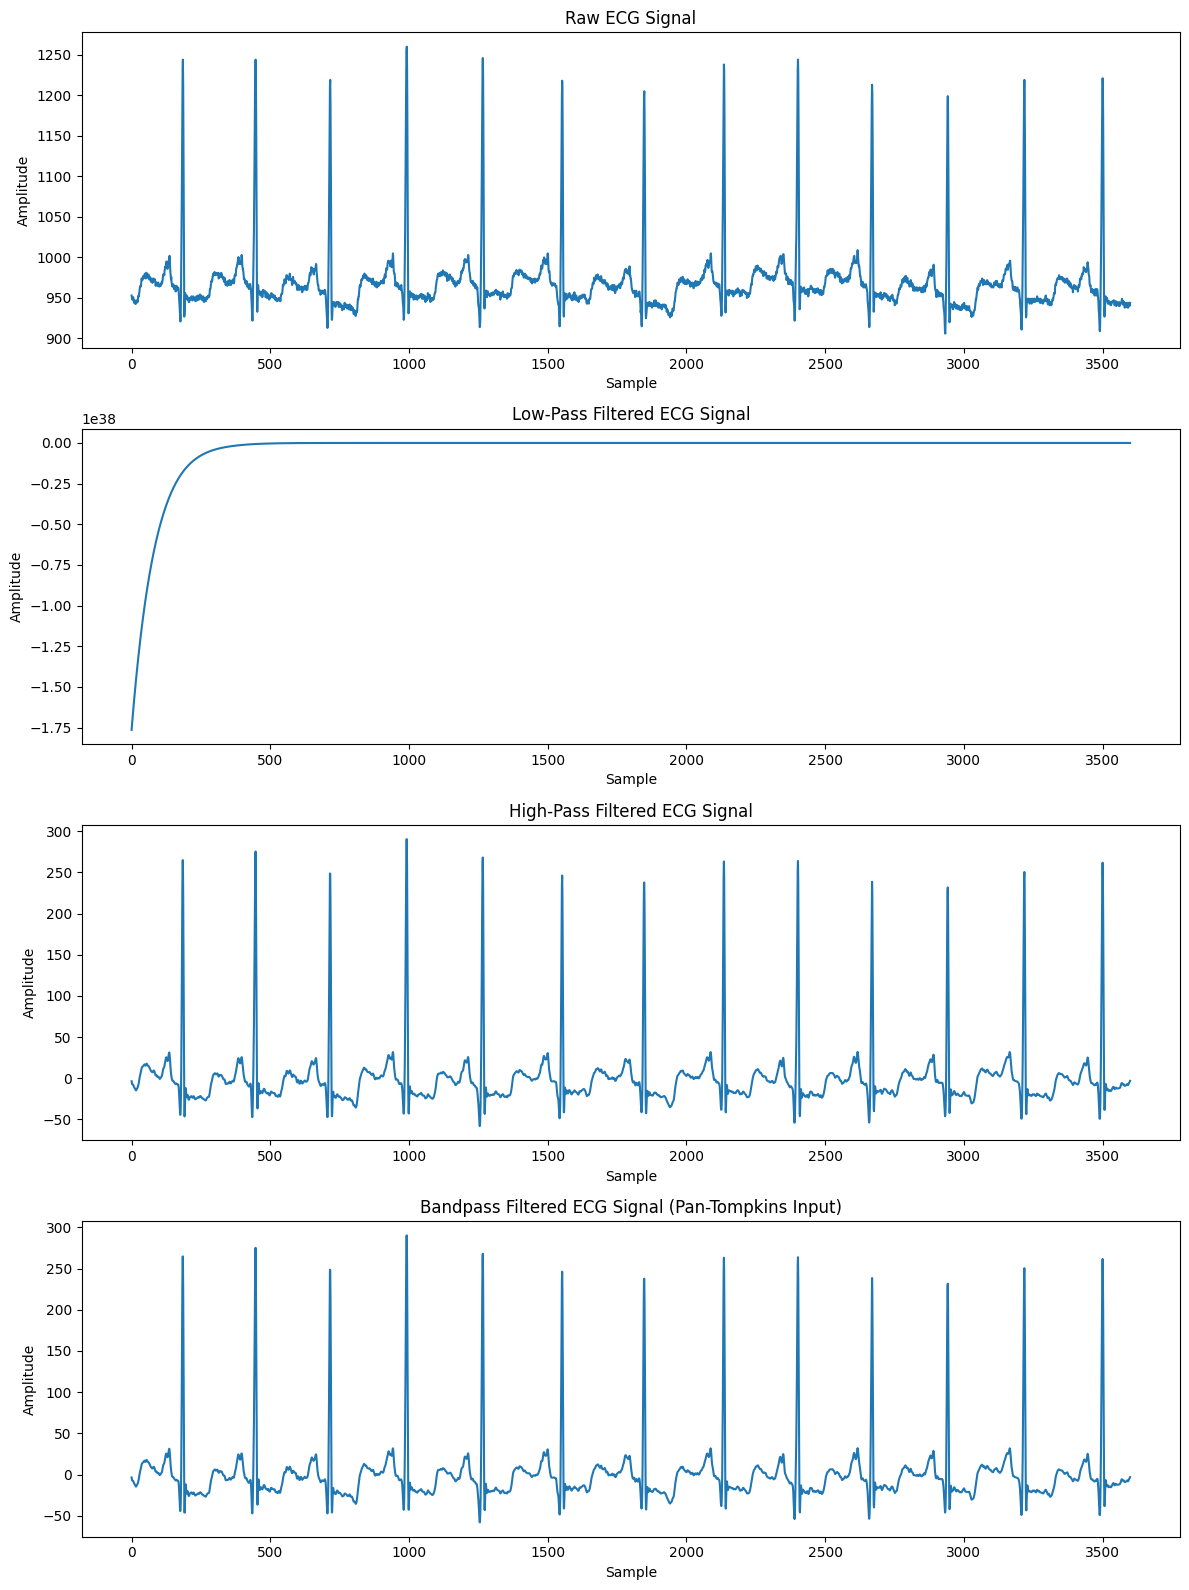

In [76]:
import numpy as np
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt

# Load ECG data
mat_data = loadmat("100m (0).mat")
ecg = mat_data['val'].flatten()
# Sampling frequency of the ECG signal (Hz)
fs = 360
# Helper function to filter the ECG signal
def bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

plt.figure(figsize=(12, 16))

# Raw ECG signal
plt.subplot(4, 1, 1)
plt.plot(ecg)
plt.title('Raw ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Low-pass filtered signal
lowpass_ecg = bandpass_filter(ecg, 0.5, 5, fs)
plt.subplot(4, 1, 2)
plt.plot(lowpass_ecg)
plt.title('Low-Pass Filtered ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# High-pass filtered signal
highpass_ecg = bandpass_filter(ecg, 0.5, 50, fs)
plt.subplot(4, 1, 3)
plt.plot(highpass_ecg)
plt.title('High-Pass Filtered ECG Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Bandpass filtered signal (Pan-Tompkins input)
bandpass_ecg = bandpass_filter(ecg, 0.5, 50, fs)
plt.subplot(4, 1, 4)
plt.plot(bandpass_ecg)
plt.title('Bandpass Filtered ECG Signal (Pan-Tompkins Input)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

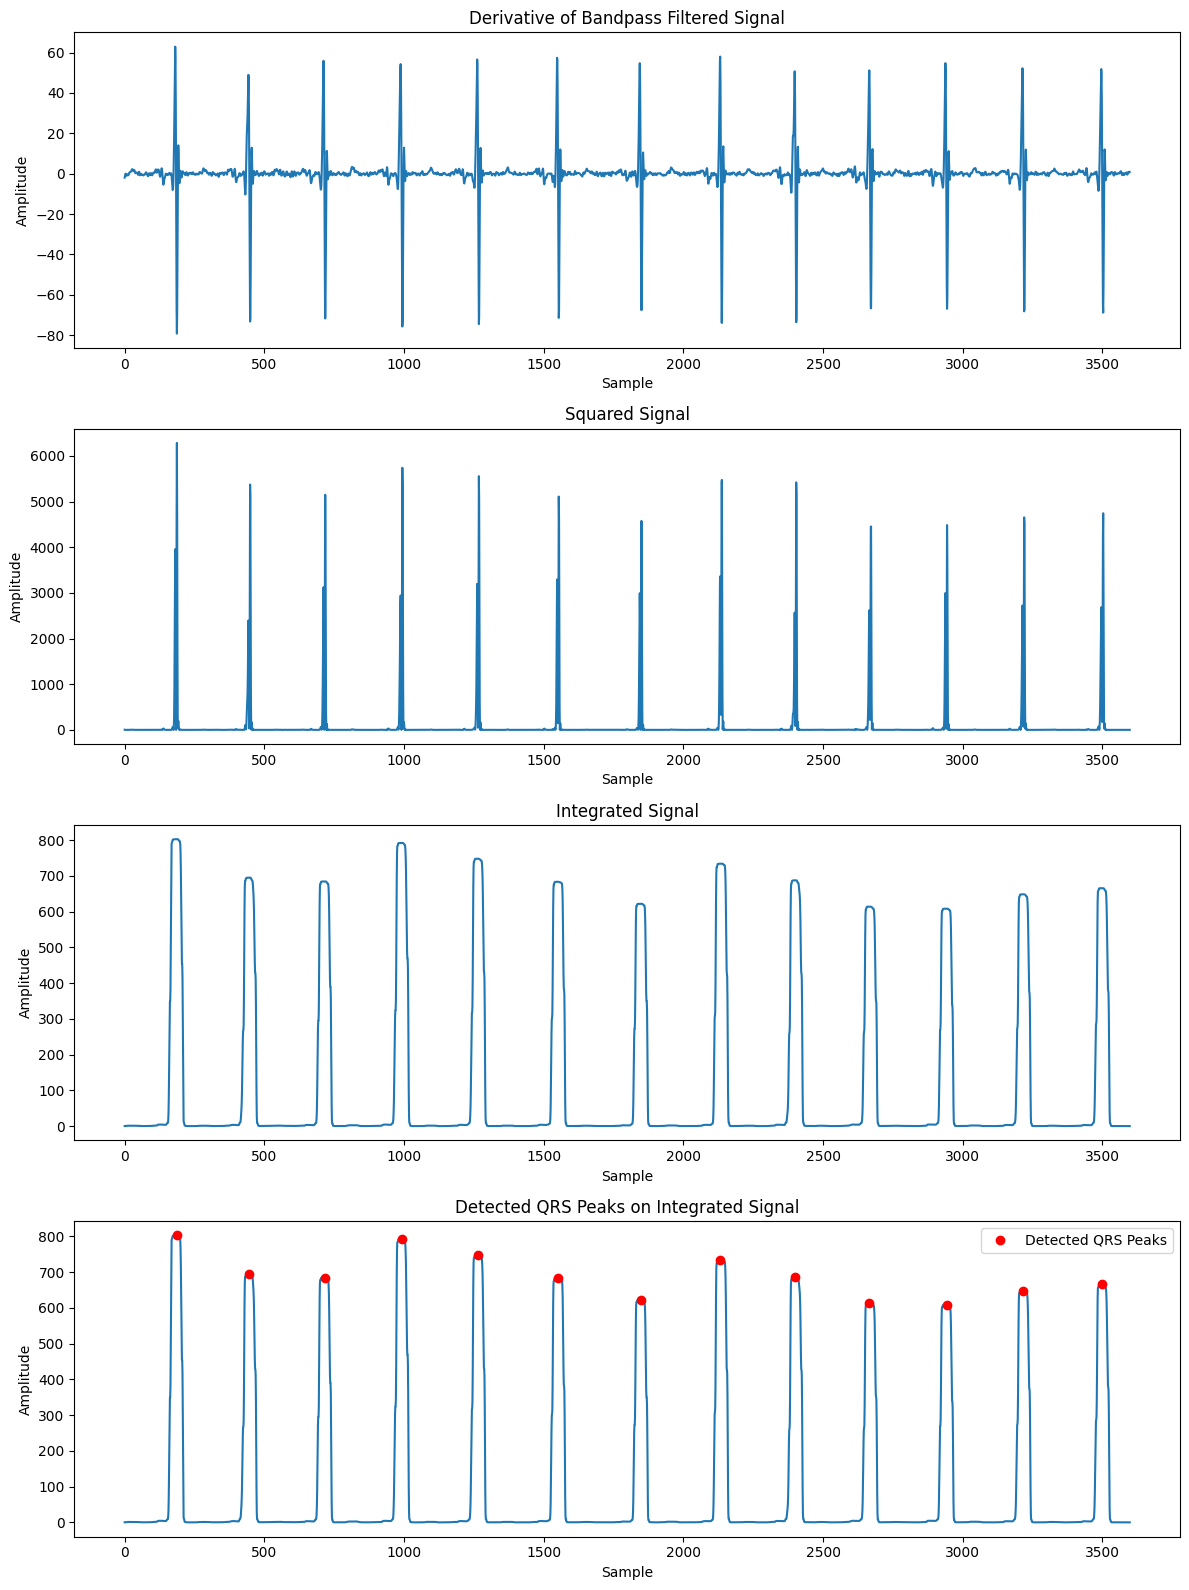

In [77]:
# Helper function to calculate the derivative of the signal
def derivative(signal):
    derivative_signal = np.diff(signal)
    return derivative_signal

# Helper function to square the signal
def square(signal):
    squared_signal = signal ** 2
    return squared_signal

# Helper function to integrate the signal
def integrate(signal, window_size):
    integrated_signal = np.convolve(signal, np.ones(window_size)/window_size, mode='same')
    return integrated_signal

# Helper function to detect QRS peaks using find_peaks
def detect_qrs_peaks(signal, threshold, min_distance):
    peaks, _ = find_peaks(signal, height=threshold, distance=min_distance)
    return peaks

plt.figure(figsize=(12, 16))

# Derivative of the signal
derivative_ecg = derivative(bandpass_ecg)
plt.subplot(4, 1, 1)
plt.plot(derivative_ecg)
plt.title('Derivative of Bandpass Filtered Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Squared signal
squared_ecg = square(derivative_ecg)
plt.subplot(4, 1, 2)
plt.plot(squared_ecg)
plt.title('Squared Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Integrated signal
window_size = int(0.12 * fs)
integrated_ecg = integrate(squared_ecg, window_size)
plt.subplot(4, 1, 3)
plt.plot(integrated_ecg)
plt.title('Integrated Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Detected QRS peaks on the integrated signal
plt.subplot(4, 1, 4)
plt.plot(integrated_ecg)
plt.plot(qrs_peaks, integrated_ecg[qrs_peaks], 'ro', label='Detected QRS Peaks')
plt.title('Detected QRS Peaks on Integrated Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

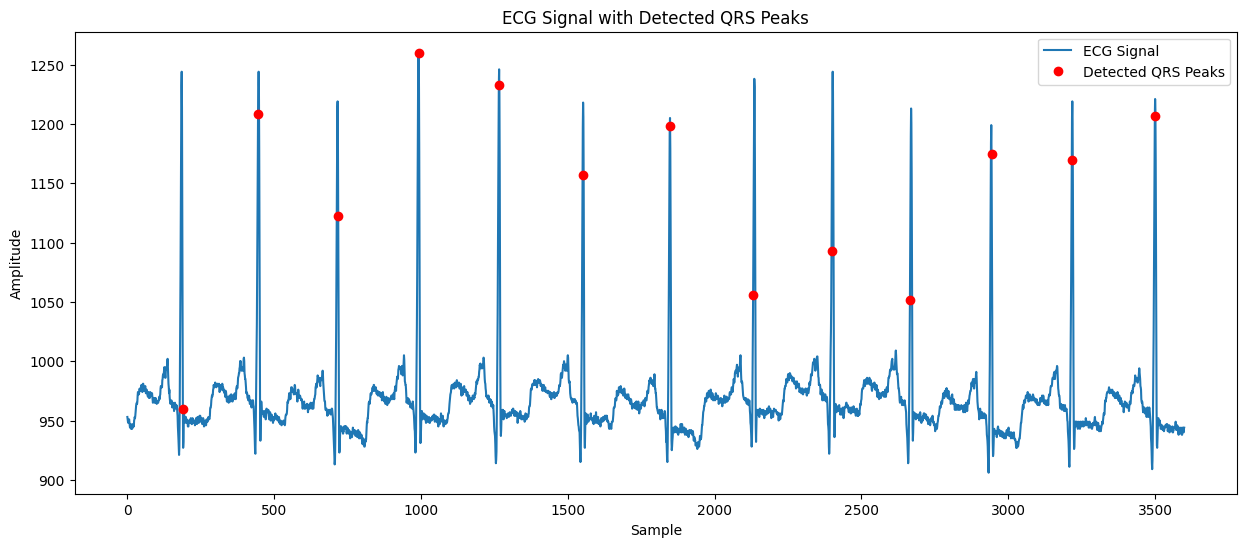

In [83]:
# Pan-Tompkins QRS detection algorithm
def pan_tompkins_qrs_detection(ecg_signal, fs):
    # Bandpass filter the ECG signal
    filtered_ecg = bandpass_filter(ecg_signal, 0.5, 50, fs)

    # Calculate derivative and square it
    derivative_ecg = derivative(filtered_ecg)
    squared_ecg = square(derivative_ecg)

    # Integrate over a window to emphasize QRS complex
    window_size = int(0.12 * fs)
    integrated_ecg = integrate(squared_ecg, window_size)

    # Find the threshold for QRS detection
    threshold = 0.6 * np.max(integrated_ecg)

    # Minimum distance between successive QRS peaks
    min_distance = int(0.2 * fs)

    # Detect QRS peaks
    qrs_peaks = detect_qrs_peaks(integrated_ecg, threshold, min_distance)

    return qrs_peaks

# Run Pan-Tompkins algorithm
qrs_peaks = pan_tompkins_qrs_detection(ecg, fs)

# Plot the original ECG signal and detected QRS peaks
plt.figure(figsize=(15, 6))
plt.plot(ecg, label='ECG Signal')
plt.plot(qrs_peaks, ecg[qrs_peaks], 'ro', label='Detected QRS Peaks')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('ECG Signal with Detected QRS Peaks')
plt.legend()
plt.show()

In [79]:
# Calculate heart rate in beats per minute (BPM)
def calculate_heart_rate(qrs_peaks, fs):
    rr_intervals = np.diff(qrs_peaks) / fs  # RR intervals in seconds
    heart_rate = 60 / np.mean(rr_intervals)  # Calculate average heart rate in BPM
    return heart_rate

# Calculate heart rate variability (SDNN) in milliseconds
def calculate_hrv(qrs_peaks, fs):
    rr_intervals = np.diff(qrs_peaks) / fs  # RR intervals in seconds
    hrv = np.std(rr_intervals) * 1000  # Convert to milliseconds
    return hrv

# Calculate heart rate and heart rate variability
heart_rate = calculate_heart_rate(qrs_peaks, fs)
hrv = calculate_hrv(qrs_peaks, fs)

# Display heart rate and HRV
print(f"Heart Rate: {heart_rate:.2f} BPM")
print(f"Heart Rate Variability (SDNN): {hrv:.2f} ms")

Heart Rate: 78.31 BPM
Heart Rate Variability (SDNN): 28.14 ms


In [80]:
# Calculate SDNN (Standard Deviation of NN intervals) in milliseconds
def calculate_sdnn(qrs_peaks, fs):
    rr_intervals = np.diff(qrs_peaks) / fs  # RR intervals in seconds
    sdnn = np.std(rr_intervals) * 1000  # Convert to milliseconds
    return sdnn

# Calculate RMSSD (Root Mean Square of Successive Differences) in milliseconds
def calculate_rmssd(qrs_peaks, fs):
    rr_intervals = np.diff(qrs_peaks) / fs  # RR intervals in seconds
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2)) * 1000  # Convert to milliseconds
    return rmssd

# Calculate SDSD (Standard Deviation of Successive Differences) in milliseconds
def calculate_sdsd(qrs_peaks, fs):
    rr_intervals = np.diff(qrs_peaks) / fs  # RR intervals in seconds
    sdsd = np.std(np.diff(rr_intervals)) * 1000  # Convert to milliseconds
    return sdsd

# Calculate NNSD (Mean of Successive Differences) in milliseconds
def calculate_nnsd(qrs_peaks, fs):
    rr_intervals = np.diff(qrs_peaks) / fs  # RR intervals in seconds
    nnsd = np.mean(np.diff(rr_intervals)) * 1000  # Convert to milliseconds
    return nnsd

# Calculate HRV measures
sdnn = calculate_sdnn(qrs_peaks, fs)
rmssd = calculate_rmssd(qrs_peaks, fs)
sdsd = calculate_sdsd(qrs_peaks, fs)
nnsd = calculate_nnsd(qrs_peaks, fs)

# Display HRV measures
print(f"SDNN: {sdnn:.2f} ms")
print(f"RMSSD: {rmssd:.2f} ms")
print(f"SDSD: {sdsd:.2f} ms")
print(f"NNSD: {nnsd:.2f} ms")

SDNN: 28.14 ms
RMSSD: 30.00 ms
SDSD: 29.21 ms
NNSD: 6.82 ms
